Reference notebook: https://www.kaggle.com/code/thesnak/breast-cancer-classification-96-89/notebook

In [ ]:
# setting up drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extracting images from drive
!unzip drive/My\ Drive/ML\ final\ project/data/images.zip -d data/
clear_output()

In [ ]:
# getting images from path
import glob

images = glob.glob('data/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for i in images[:3]:
  print(i)

data/IDC_regular_ps50_idx5/9176/0/9176_idx5_x1201_y1251_class0.png
data/IDC_regular_ps50_idx5/9176/0/9176_idx5_x501_y1951_class0.png
data/IDC_regular_ps50_idx5/9176/0/9176_idx5_x2301_y701_class0.png


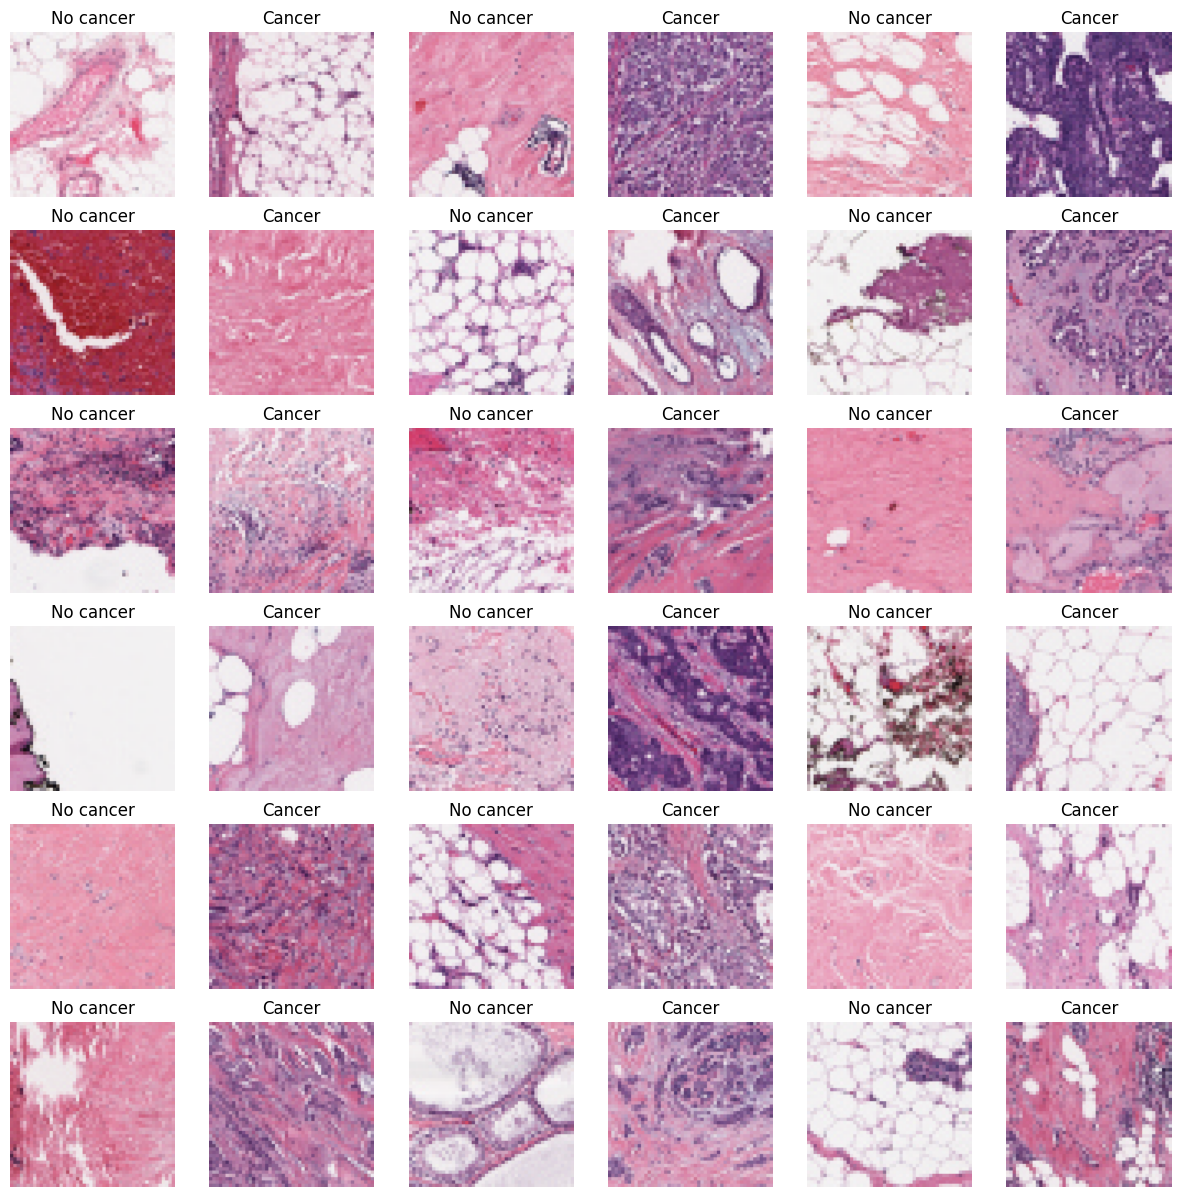

In [ ]:
# showing examples of images with cancer and images without cancer
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image

no_idc = []
idc = []

for i in images:
  if i[-5] == '1':
    idc.append(i)
  elif i[-5] == '0':
    no_idc.append(i)

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(no_idc), 18)
some_can = np.random.randint(0, len(idc), 18)

s = 0
for num in some_non:
    
        img = image.load_img((no_idc[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('No cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((idc[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('Cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

In [ ]:
# converting images to pixel values
import cv2

image_arr = []
sizes_no_idc = []
sizes_idc = []

for i in no_idc:
  img = cv2.imread(i, cv2.IMREAD_COLOR)
  sizes_no_idc.append(img.shape[0] * img.shape[1])
  img_size = cv2.resize(img, (50, 50), interpolation = cv2.INTER_LINEAR)
  image_arr.append([img_size, 0])

for i in idc:
  img = cv2.imread(i, cv2.IMREAD_COLOR)
  sizes_idc.append(img.shape[0] * img.shape[1])
  img_size = cv2.resize(img, (50, 50), interpolation = cv2.INTER_LINEAR)
  image_arr.append([img_size, 1])

In [ ]:
set(sizes_idc)

{1550, 1850, 1900, 2100, 2200, 2450, 2500}

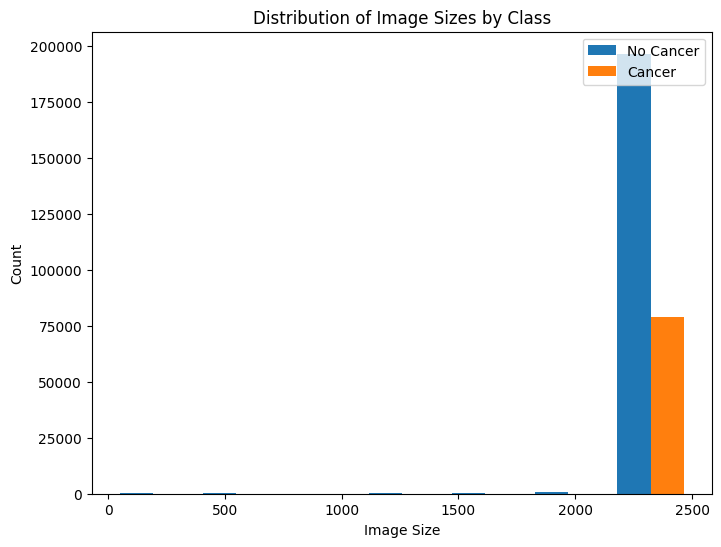

In [ ]:
# Plot histogram of image sizes
plt.figure(figsize=(8, 6))
plt.hist([sizes_no_idc, sizes_idc], bins=7, label=['No Cancer', 'Cancer'])
plt.legend(loc='upper right')
plt.title('Distribution of Image Sizes by Class')
plt.xlabel('Image Size')
plt.ylabel('Count')
plt.show()

In [ ]:
import gc

del images
del no_idc
del idc
del sizes_no_idc
del sizes_idc

gc.collect()

102

In [ ]:
# shuffling images and separating into X and y
import random

random.shuffle(image_arr)

X = []
y = []

for feature, label in image_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [ ]:
# splitting into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [ ]:
del image_arr
del X
del y

gc.collect()

0

In [ ]:
a,b,c,d = x_train[:6000], y_train[:6000], x_test[:6000], y_test[:6000]

In [ ]:
!pip install "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 48.3 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [ ]:
import tensorflow as tf
import tensorflow.keras.applications as models

# training function for hyperparameter tuning
def train(config):
  model = tf.keras.Sequential()

  base_resnet = models.ResNet50(include_top = False, input_shape = (50,50,3), pooling=config['pooling'], classes=2, weights='imagenet')
  for layer in base_resnet.layers:
    layer.trainable = False

  model.add(base_resnet)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(512, activation='relu'))
  model.add(tf.keras.layers.Dropout(config['dropout']))
  model.add(tf.keras.layers.Dense(2, activation='softmax'))

  optimizer = tf.keras.optimizers.Adam(learning_rate = config['lr'])

  model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  # default batch size is 32
  model.fit(a, b, validation_data=(c, d), epochs=5, callbacks=[TuneReportCallback({"mean_accuracy": "accuracy"})])

In [ ]:
# hyperparameter tuning with grid search and hyperband scheduler
# first hyperparameter tuning run; we ran another one below this due to dropout selection messing up models
import ray
from ray import tune
from ray.tune.integration.keras import TuneReportCallback
from ray.tune.schedulers import HyperBandScheduler

hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration',
    metric='mean_accuracy',
    mode='max',
    max_t=10,
    reduction_factor=3)

# Grid search
analysis = tune.run(
    train,
    name="exp",
    resources_per_trial={
        "gpu": 1,
        "cpu": 2
    },
    config={
      "opt": tune.grid_search(['adam', 'sgd']),
      "pooling": tune.grid_search(['avg', 'max']),
      "lr": tune.grid_search([0.001, 0.01, 0.1]),
      "batch_size": tune.grid_search([32,64,128,256]),
      "dropout": tune.grid_search([0.1, 0.2, 0.3])
    })

2023-05-10 22:43:55,317	WARNING worker.py:1986 -- Warning: The actor ImplicitFunc is very large (71 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-05-10 22:43:55,520	WARNING util.py:244 -- The `start_trial` operation took 1.416 s, which may be a performance bottleneck.
(pid=22745) 2023-05-10 22:44:01.722621: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(train pid=22745) 2023-05-10 22:44:07.775326: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


(train pid=22745) Epoch 1/5
157/157 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.7820


Trial name,date,done,experiment_tag,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_1a57b_00000,2023-05-10_22-44-50,True,"0_batch_size=32,dropout=0.5870,lr=0.0010,opt=adam,pooling=avg",b334a7f15816,5,0.8428,172.28.0.12,22745,46.0064,4.5998,46.0064,1683758690,5,1a57b_00000
train_1a57b_00001,2023-05-10_22-45-34,True,"1_batch_size=64,dropout=0.0936,lr=0.0010,opt=adam,pooling=avg",b334a7f15816,5,0.8796,172.28.0.12,23231,37.3877,4.22465,37.3877,1683758734,5,1a57b_00001
train_1a57b_00002,2023-05-10_22-46-16,True,"2_batch_size=128,dropout=0.1676,lr=0.0010,opt=adam,pooling=avg",b334a7f15816,5,0.8822,172.28.0.12,23672,35.4712,4.48557,35.4712,1683758776,5,1a57b_00002
train_1a57b_00003,2023-05-10_22-46-58,True,"3_batch_size=256,dropout=0.7996,lr=0.0010,opt=adam,pooling=avg",b334a7f15816,5,0.831,172.28.0.12,24093,35.8053,4.63317,35.8053,1683758818,5,1a57b_00003
train_1a57b_00004,2023-05-10_22-47-40,True,"4_batch_size=32,dropout=0.8093,lr=0.0100,opt=adam,pooling=avg",b334a7f15816,5,0.7288,172.28.0.12,24522,35.7583,4.25553,35.7583,1683758860,5,1a57b_00004
train_1a57b_00005,2023-05-10_22-48-22,True,"5_batch_size=64,dropout=0.6796,lr=0.0100,opt=adam,pooling=avg",b334a7f15816,5,0.7866,172.28.0.12,24940,35.2794,5.01763,35.2794,1683758902,5,1a57b_00005
train_1a57b_00006,2023-05-10_22-49-04,True,"6_batch_size=128,dropout=0.0357,lr=0.0100,opt=adam,pooling=avg",b334a7f15816,5,0.859,172.28.0.12,25363,35.3535,4.23515,35.3535,1683758944,5,1a57b_00006
train_1a57b_00007,2023-05-10_22-49-45,True,"7_batch_size=256,dropout=0.3152,lr=0.0100,opt=adam,pooling=avg",b334a7f15816,5,0.8338,172.28.0.12,25779,36.018,4.56932,36.018,1683758985,5,1a57b_00007
train_1a57b_00008,2023-05-10_22-50-28,True,"8_batch_size=32,dropout=0.3123,lr=0.1000,opt=adam,pooling=avg",b334a7f15816,5,0.7174,172.28.0.12,26199,36.2667,4.47848,36.2667,1683759028,5,1a57b_00008
train_1a57b_00009,2023-05-10_22-51-10,True,"9_batch_size=64,dropout=0.4949,lr=0.1000,opt=adam,pooling=avg",b334a7f15816,5,0.7476,172.28.0.12,26635,36.0395,4.30489,36.0395,1683759070,5,1a57b_00009


(train pid=19537) 2023-05-11 04:01:14.794460: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45000000 exceeds 10% of free system memory.
(train pid=19537) 2023-05-11 04:01:14.882653: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 45000000 exceeds 10% of free system memory.


188/188 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.7995


Trial name,date,done,hostname,iterations_since_restore,mean_accuracy,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_5ca35_00000,2023-05-11_04-01-40,True,d5477e0dc5a0,5,0.880333,172.28.0.12,19537,42.7789,5.01497,42.7789,1683777700,5,5ca35_00000
train_5ca35_00001,2023-05-11_04-02-31,True,d5477e0dc5a0,5,0.8715,172.28.0.12,20020,41.201,5.04492,41.201,1683777751,5,5ca35_00001
train_5ca35_00002,2023-05-11_04-03-22,True,d5477e0dc5a0,5,0.8735,172.28.0.12,20500,41.086,5.42495,41.086,1683777802,5,5ca35_00002
train_5ca35_00003,2023-05-11_04-04-12,True,d5477e0dc5a0,5,0.870833,172.28.0.12,20992,42.2849,6.18321,42.2849,1683777852,5,5ca35_00003
train_5ca35_00004,2023-05-11_04-05-02,True,d5477e0dc5a0,5,0.8675,172.28.0.12,21465,42.9172,6.18863,42.9172,1683777902,5,5ca35_00004
train_5ca35_00005,2023-05-11_04-05-52,True,d5477e0dc5a0,5,0.862,172.28.0.12,21951,42.0008,5.30218,42.0008,1683777952,5,5ca35_00005
train_5ca35_00006,2023-05-11_04-06-43,True,d5477e0dc5a0,5,0.869667,172.28.0.12,22430,41.771,5.17159,41.771,1683778003,5,5ca35_00006
train_5ca35_00007,2023-05-11_04-07-34,True,d5477e0dc5a0,5,0.872333,172.28.0.12,22919,41.5872,5.17282,41.5872,1683778054,5,5ca35_00007
train_5ca35_00008,2023-05-11_04-08-26,True,d5477e0dc5a0,5,0.867,172.28.0.12,23406,43.8966,6.43419,43.8966,1683778106,5,5ca35_00008
train_5ca35_00009,2023-05-11_04-09-17,True,d5477e0dc5a0,5,0.860667,172.28.0.12,23908,43.376,6.53448,43.376,1683778157,5,5ca35_00009


In [ ]:
# best hyerparameters: batch_size = 256, dropout = .2, lr = .001, opt = adam, pooling = avg

In [ ]:
# Model 2: loading pretrained resnet and using hyperparameter tuned model
import tensorflow as tf
import tensorflow.keras.applications as models

model3 = tf.keras.Sequential()

base_resnet3 = models.ResNet50(include_top = False, input_shape = (50,50,3), pooling='avg', classes=2, weights='imagenet')

for layer in base_resnet3.layers:
  layer.trainable = False

model3.add(base_resnet3)
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(512, activation='relu'))
model3.add(tf.keras.layers.Dropout(0.2))
model3.add(tf.keras.layers.Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = .001)
model3.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(x_train, y_train, batch_size = 256, validation_data=(x_test, y_test), epochs=12)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/12
868/868 [==============================] - 80s 76ms/step - loss: 0.3779 - accuracy: 0.8462 - val_loss: 0.3385 - val_accuracy: 0.8564
Epoch 2/12
868/868 [==============================] - 73s 84ms/step - loss: 0.3329 - accuracy: 0.8592 - val_loss: 0.3294 - val_accuracy: 0.8586
Epoch 3/12
868/868 [==============================] - 74s 85ms/step - loss: 0.3241 - accuracy: 0.8637 - val_loss: 0.3270 - val_accuracy: 0.8631
Epoch 4/12
868/868 [==============================] - 74s 85ms/step - loss: 0.3185 - accuracy: 0.8662 - val_loss: 0.3245 - val_accuracy: 0.8612
Epoch 5/12
868/868 [==============================] - 74s 85ms/step - loss: 0.3136 - accuracy: 0.8686 - val_loss: 0.3253 - val_accuracy: 0.8639
Epoch 6/12
868/868 [==============================] - 74s 85ms/step - loss: 0.3086 - accuracy: 0.8711 - val_loss: 0.3239 - val_accuracy: 0.8635
Epoch 7/12
868/868 [==============================] - 74s 85ms/step - l

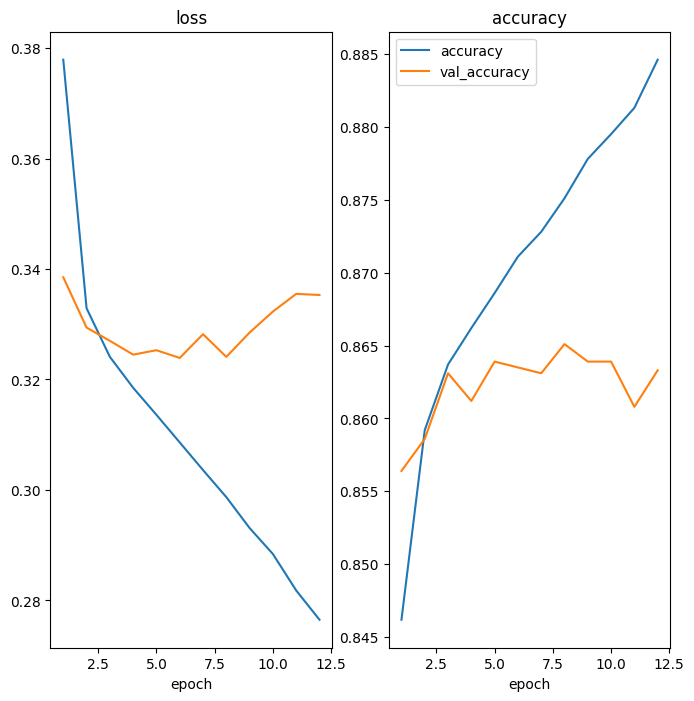

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8,8))
loss = [0.3779, 0.3329, 0.3241, 0.3185, 0.3136, 0.3086, 0.3036, 0.2987, 0.2931, 0.2884, 0.2818, 0.2765]
accuracy = [0.8462, 0.8592, 0.86370, .86620, .86860, .87110, .87280, .87510, .8778, .8795, 0.8813, 0.8846]
val_loss = [0.3385, 0.3294, 0.32700, 0.3245, 0.3253, .32390, .32820, .32410, .32850, .33230, .33550, .3353]
val_accuracy = [0.8564, 0.85860, .86310, .86120, .86390, .86350, .8631, 0.86510, .86390, .86390, .86080, .8633]

plt.subplot(1,2,1)
plt.plot(np.arange(1,13), loss, label='loss')
plt.plot(np.arange(1,13), val_loss, label='val_loss')
plt.title('loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(np.arange(1,13), accuracy, label='accuracy')
plt.plot(np.arange(1,13), val_accuracy, label='val_accuracy')
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# Model 1: loading pretrained resnet and adding fc layers
import tensorflow as tf
import tensorflow.keras.applications as models

model = tf.keras.Sequential()

base_resnet = models.ResNet50(include_top = False, input_shape = (50,50,3), pooling='avg', classes=2, weights='imagenet')
for layer in base_resnet.layers:
  layer.trainable = False

model.add(base_resnet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = .001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# default batch size is 32
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/5
6939/6939 [==============================] - 172s 23ms/step - loss: 0.3561 - accuracy: 0.8498 - val_loss: 0.3491 - val_accuracy: 0.8508
Epoch 2/5
6939/6939 [==============================] - 132s 19ms/step - loss: 0.3304 - accuracy: 0.8601 - val_loss: 0.3346 - val_accuracy: 0.8580
Epoch 3/5
6939/6939 [==============================] - 150s 22ms/step - loss: 0.3217 - accuracy: 0.8641 - val_loss: 0.3280 - val_accuracy: 0.8592
Epoch 4/5
6939/6939 [==============================] - 150s 22ms/step - loss: 0.3146 - accuracy: 0.8674 - val_loss: 0.3357 - val_accuracy: 0.8581
Epoch 5/5
6939/6939 [==============================] - 151s 22ms/step - loss: 0.3085 - accuracy: 0.8701 - val_loss: 0.3267 - val_accuracy: 0.8630


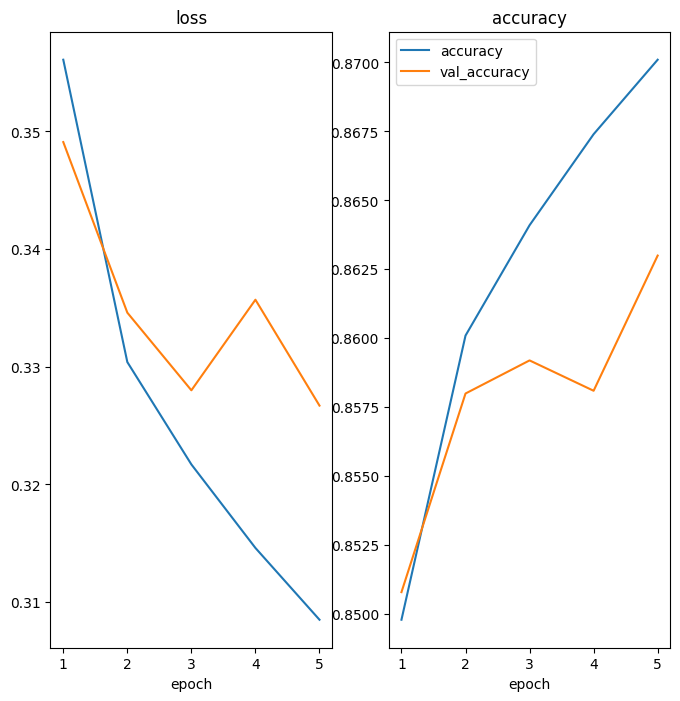

In [ ]:
plt.figure(figsize=(8,8))
loss = [0.3561, 0.3304, 0.3217, 0.3146, .3085]
accuracy = [.8498, 0.8601,  0.8641, 0.8674, 0.8701]
val_loss = [0.3491, 0.3346, 0.3280, 0.3357, 0.3267]
val_accuracy = [0.8508, 0.8580, .8592, 0.8581, 0.8630]

plt.subplot(1,2,1)
plt.plot(np.arange(1,6), loss, label='loss')
plt.plot(np.arange(1,6), val_loss, label='val_loss')
plt.title('loss')
plt.xlabel('epoch')
plt.subplot(1,2,2)
plt.plot(np.arange(1,6), accuracy, label='accuracy')
plt.plot(np.arange(1,6), val_accuracy, label='val_accuracy')
plt.title('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
# no pretrained weights (done for experimentation)
import tensorflow as tf
import tensorflow.keras.applications as models

model2 = tf.keras.Sequential()

base_resnet2 = models.ResNet50(include_top = False, input_shape = (50,50,3), pooling='avg', classes=2, weights=None)

#for layer in base_resnet.layers:
#  layer.trainable = False

model2.add(base_resnet2)
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(512, activation='relu'))
model2.add(tf.keras.layers.Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate = .001)
model2.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# default batch size is 32
history2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
6939/6939 [==============================] - 470s 60ms/step - loss: 0.3719 - accuracy: 0.8410 - val_loss: 0.5639 - val_accuracy: 0.7757
Epoch 2/5
6939/6939 [==============================] - 411s 59ms/step - loss: 0.3258 - accuracy: 0.8611 - val_loss: 1.2127 - val_accuracy: 0.5115
Epoch 3/5
6939/6939 [==============================] - 411s 59ms/step - loss: 0.3044 - accuracy: 0.8710 - val_loss: 0.6013 - val_accuracy: 0.7961
Epoch 4/5
6939/6939 [==============================] - 406s 59ms/step - loss: 0.2936 - accuracy: 0.8757 - val_loss: 0.3175 - val_accuracy: 0.8701
Epoch 5/5
6939/6939 [==============================] - 387s 56ms/step - loss: 0.2867 - accuracy: 0.8785 - val_loss: 0.5671 - val_accuracy: 0.7118


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24,637,826
Trainable params: 24,584,706
Non-trainable params: 53,120
_________________________________________________________________
